In [20]:
import os
import time
 
import re
import random
import xml.etree.ElementTree as et
from PIL import Image
 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications, layers
print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


# 데이터 다운로드

In [3]:
import gdown
url = 'https://drive.google.com/u/0/uc?id=1KzV_M92s5JntEGNx0OxZA4p2PLoL2eoT&export=download'
fname = 'covid_mask_datasets.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1KzV_M92s5JntEGNx0OxZA4p2PLoL2eoT&export=download
To: /content/covid_mask_datasets.zip
217MB [00:02, 79.2MB/s]


'covid_mask_datasets.zip'

In [4]:
## 압축풀기
!unzip -q covid_mask_datasets.zip -d covid_mask_datasets

In [5]:
## 압축이 풀린 directory 확인
!ls -al covid_mask_datasets

total 12
drwxr-xr-x 3 root root 4096 Sep 22 07:08  .
drwxr-xr-x 1 root root 4096 Sep 22 07:08  ..
drwxr-xr-x 5 root root 4096 Sep 22 07:08 'New Masks Dataset'


In [6]:
!pwd

/content


# 하이퍼 파라미터

In [7]:
# 경로 설정
train_dir = '/content/covid_mask_datasets/New Masks Dataset/Train'
test_dir = '/content/covid_mask_datasets/New Masks Dataset/Test'
val_dir = '/content/covid_mask_datasets/New Masks Dataset/Validation'

In [22]:
N_BATCHS=32
N_EPOCHS = 10
img_height=224
img_width=224

LEARNING_RATE = 0.001

# Image Augmentation

## Image Data Generator

In [10]:
data_gen_args_train = dict(rescale = 1/255.0,
                           rotation_range=40, 
                            brightness_range=[0.7, 1.3], 
                            zoom_range=0.2, 
                            horizontal_flip=True, 
                            width_shift_range=0.2, 
                            height_shift_range=0.2, 
                            fill_mode='constant')
data_gen_args_base = dict(rescale = 1/255.0)


In [11]:
train_data_gen = ImageDataGenerator(**data_gen_args_train)
val_data_gen = ImageDataGenerator(**data_gen_args_base)
test_data_gen = ImageDataGenerator(**data_gen_args_base)

train_data_iter = train_data_gen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size = N_BATCHS, class_mode='binary')
val_data_iter = val_data_gen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size = N_BATCHS, class_mode='binary')
test_data_iter = test_data_gen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size = N_BATCHS, class_mode='binary')



Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


--> 3개의 image data iterator를 만들면 된다

## 샘플 이미지 확인하기

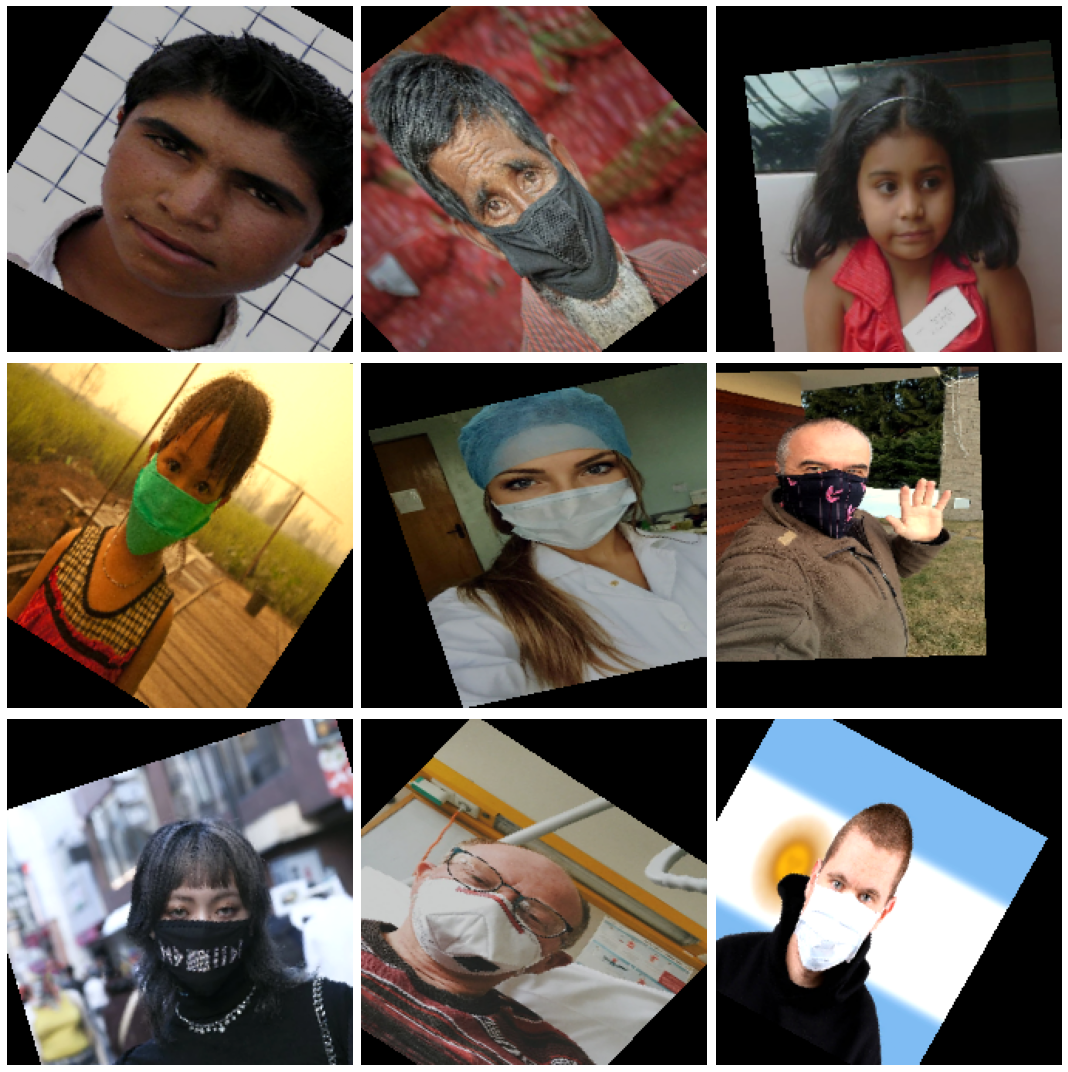

In [12]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    batch = next(train_data_iter)
    plt.imshow(batch[0][0])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Model Building
전이학습을 이용한 모델 빌딩

In [15]:
def create_model():
    model = keras.Sequential()
    
    # Feature Extractor (Conv base) - 기존 Pretrained 모델을 사용 (VGG16)
    conv_base = applications.VGG16(include_top=False, input_shape=(img_height, img_width, 3))
    # model에 conv_base를 추가
    
    conv_base.trainable = False #모델 학습시 weight를 최적화(update) 하지 않도록 설정. - frozon => 모델 컴파일 전에 설정해야 한다.
    model.add(conv_base) #conv_base의 layer들이 model에 추가.
    
    # Classification - 새로 정의
    model.add(layers.GlobalAveragePooling2D()) # 3차원->1차원 : GAP
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    return model

## Compile

In [23]:
model = create_model()
model.compile(optimizer = keras.optimizers.Adam(LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


## Callback functions

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
save_path = '/content/drive/MyDrive/deeplearning_src/mask_detection'
mc_callback=keras.callbacks.ModelCheckpoint(filepath=save_path, save_best_only=True, monitor='val_loss', verbose=2)


## Fitting

In [28]:
hist = model.fit(train_data_iter, epochs=N_EPOCHS,
                   steps_per_epoch=len(train_data_iter),
                   validation_data=val_data_iter,
                   validation_steps=len(val_data_iter),
                   callbacks=[mc_callback])

Epoch 1/10
19/19 [==============================] - 73s 2s/step - loss: 0.7842 - accuracy: 0.5050 - val_loss: 0.6841 - val_accuracy: 0.5882

Epoch 00001: val_loss improved from inf to 0.68405, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection
INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets
Epoch 2/10
19/19 [==============================] - 20s 1s/step - loss: 0.6789 - accuracy: 0.5567 - val_loss: 0.6668 - val_accuracy: 0.5490

Epoch 00002: val_loss improved from 0.68405 to 0.66683, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection
INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets
Epoch 3/10
19/19 [==============================] - 19s 1s/step - loss: 0.6613 - accuracy: 0.6867 - val_loss: 0.6344 - val_accuracy: 0.7810

Epoch 00003: val_loss improved from 0.66683 to 0.63435, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection
INFO:t

## 다른 모델 써보기

In [30]:
def create_model_2():
    model = keras.Sequential()
    

    conv_base = applications.MobileNet(include_top=False, input_shape=(img_height, img_width, 3))
    
    conv_base.trainable = False 
    model.add(conv_base)
    
    # Classification - 새로 정의
    model.add(layers.GlobalAveragePooling2D()) # 3차원->1차원 : GAP


    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))



    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    return model

In [31]:
model_2 = create_model_2()
model_2.compile(optimizer = keras.optimizers.Adam(LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 3,756,225
Trainable params: 526,337
Non-t

In [32]:
hist = model_2.fit(train_data_iter, epochs=N_EPOCHS,
                   steps_per_epoch=len(train_data_iter),
                   validation_data=val_data_iter,
                   validation_steps=len(val_data_iter),
                   callbacks=[mc_callback])

Epoch 1/10
19/19 [==============================] - 22s 1s/step - loss: 0.1695 - accuracy: 0.9267 - val_loss: 0.8520 - val_accuracy: 0.7255

Epoch 00001: val_loss did not improve from 0.49102
Epoch 2/10
19/19 [==============================] - 17s 920ms/step - loss: 0.0492 - accuracy: 0.9833 - val_loss: 0.4715 - val_accuracy: 0.8464

Epoch 00002: val_loss improved from 0.49102 to 0.47152, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


Epoch 3/10
19/19 [==============================] - 18s 944ms/step - loss: 0.0546 - accuracy: 0.9800 - val_loss: 0.2240 - val_accuracy: 0.9248

Epoch 00003: val_loss improved from 0.47152 to 0.22402, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


Epoch 4/10
19/19 [==============================] - 18s 959ms/step - loss: 0.0212 - accuracy: 0.9900 - val_loss: 0.3589 - val_accuracy: 0.8987

Epoch 00004: val_loss did not improve from 0.22402
Epoch 5/10
19/19 [==============================] - 18s 964ms/step - loss: 0.0168 - accuracy: 0.9917 - val_loss: 0.1194 - val_accuracy: 0.9673

Epoch 00005: val_loss improved from 0.22402 to 0.11938, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


Epoch 6/10
19/19 [==============================] - 18s 974ms/step - loss: 0.0124 - accuracy: 0.9950 - val_loss: 0.0458 - val_accuracy: 0.9837

Epoch 00006: val_loss improved from 0.11938 to 0.04584, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


Epoch 7/10
19/19 [==============================] - 18s 972ms/step - loss: 0.0195 - accuracy: 0.9933 - val_loss: 0.0479 - val_accuracy: 0.9869

Epoch 00007: val_loss did not improve from 0.04584
Epoch 8/10
19/19 [==============================] - 18s 967ms/step - loss: 0.0131 - accuracy: 0.9933 - val_loss: 0.0333 - val_accuracy: 0.9869

Epoch 00008: val_loss improved from 0.04584 to 0.03333, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


Epoch 9/10
19/19 [==============================] - 18s 947ms/step - loss: 0.0133 - accuracy: 0.9950 - val_loss: 0.0292 - val_accuracy: 0.9869

Epoch 00009: val_loss improved from 0.03333 to 0.02921, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


Epoch 10/10
19/19 [==============================] - 18s 969ms/step - loss: 0.0138 - accuracy: 0.9967 - val_loss: 0.0193 - val_accuracy: 0.9935

Epoch 00010: val_loss improved from 0.02921 to 0.01929, saving model to /content/drive/MyDrive/deeplearning_src/mask_detection


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mask_detection/assets


# 평가

In [39]:
model = keras.models.load_model(save_path)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 3,756,225
Trainable params: 526,337
Non-trainable params: 3,229,888
______________________________________

In [41]:
model.evaluate(test_data_iter)

4/4 [==============================] - 2s 467ms/step - loss: 0.0053 - accuracy: 1.0000


[0.005263435188680887, 1.0]